In [1]:
import asyncio
import time
import math
import numpy as np
from cv2 import VideoCapture
import matplotlib.pyplot as plt
from matplotlib import colors
import Global
# from vision.module import detection, utils, constants
# from vision.functions import vision_init, get_thymio
from vision.functions import vision_init, get_thymio
# import vision_nav
import KF
from Control import Control
import cv2
from itertools import chain
import math

In [2]:
#Connecting to the tymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 459c102c-e51f-4d84-ba38-ef5cd6b70951

In [3]:
thymio = Control(node,client)

init


In [3]:
aw(node.unlock())

{'error_code': 2}

In [4]:
#thymio.set_motors(0,"forward")

Going forward


In [8]:
ls,rs,prox = await thymio.get_sensors()
display(ls)
display(rs)
display(prox)

0

0

[0, 0, 0, 0, 0, 0, 0]

In [4]:
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))

In [4]:
# lock the camera resource
cap = VideoCapture(0)

In [5]:
grid = None
obs = []
obs_grid = None
targets = []
goal = []

# import constants
from vision.constants import grid_height_cells

In [7]:
#  vision initialization

flag, grid, obs, obs_grid, targets, goal = vision_init(cap)

if not flag:
    assert 0

# if you get to this point, the vision is initialized and you have acquired information about the environment

------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [5]
 [2]]
------------------
Error in module.utils.grid_extraction: cannot classify corners correctly
------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [5]
 [2]
 [1]]
------------------


In [8]:
#Extracting targets to be in array and not matrix
targets = tuple([item for sublist in targets for item in sublist])
display(targets)

(1, 0)

In [9]:
#Extracting goal to be in array and not matrix format
goal = tuple([item for sublist in goal for item in sublist])
display(goal)

(6, 5)

In [10]:
!python -m pip install tk-tools

In [10]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

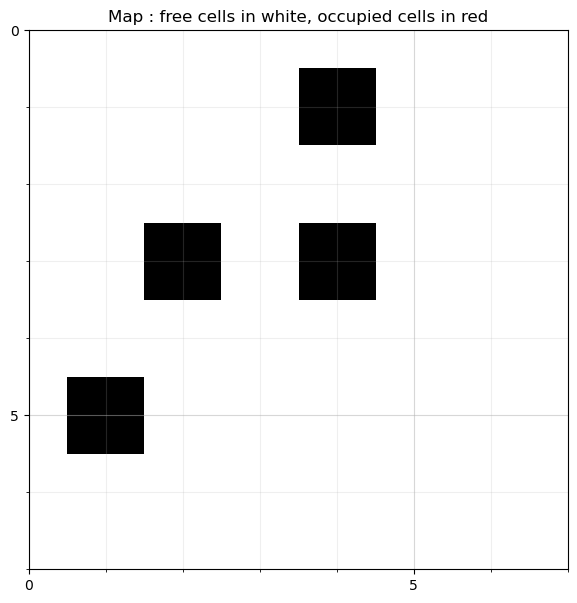

In [11]:
max_val = grid_height_cells  # here, we suppose a squared environment
fig, ax = create_empty_plot(max_val)

# set plot origin to top left 
plt.xlim(0, max_val)
plt.ylim(max_val, 0)

# Displaying the map
cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(obs_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")

In [12]:
# List of all coordinates in the grid
#max_val is the size of the map
#x: 2D array where each element x[i, j] represents the x coordinate at position (i, j) in the grid.
#Donc x[1,n] rendra toujours 1 car la coord x d'un point en (1,n) est 1
#y: 2D array where each element y[i, j] represents the y coordinate at position (i, j) in the grid.
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
#Coords countains all the possible coordinates of the grid from (0,0) to (max_val-1,max_val-1)
coords = list([(int(x[0]), int(x[1])) for x in pos])

#Defining the start  point and end goal for now on
flag, t ,state = get_thymio(cap)
if flag:
    start = tuple([state[0]-0.5,state[1]])
    angle = state[2]
else:
    print("Problem with thymio_get function")
print(t.center_pixel)
start = tuple(map(round, start))

------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [2]
 [1]
 [5]]
------------------
------------------
thymio_recognition: markers found
IDS:
[[5]]
------------------
[454, 416]


In [13]:
start

(4, 4)

In [14]:
#Defining the distance to the goal ignoring the obstacles, here using the Euclidian distance with the function np.linalg.norm
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

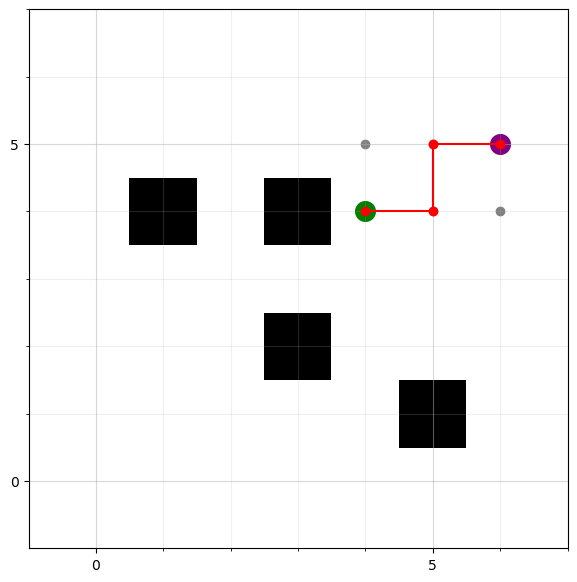

In [15]:
# Run the A* algorithm
path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N") # changed occupancy_grid by grid
path = np.array(path).reshape(-1, 2).transpose()

visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(obs_grid.transpose(), cmap=cmap) # changed occupancy_grid by grid

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'grey')
ax_astar.plot(path[0], path[1], marker="o", color = 'red')
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200)

In [22]:
thymio.set_motors(0,"forward")

Going forward
left speed: 50
righ speed: 50


In [17]:
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))


In [18]:
print(path)


[[4 4 4 4 5 5 6]
 [1 2 3 4 4 5 5]]


In [16]:
from Control import Control
#Main 
index = 0
size_path = len(path[0])
old_pos = start
target = tuple(path[:,1])
epsilon = 0.5
Kidnapping_threshold = 4
arrived = False
while size_path > index: 
    
    #Checking the state of camera
    camera_on = True
    flag, _, state = get_thymio(cap)
    if not flag:
        print("Problem with vision_nav function")
        camera_on = False
    else:
        pos = tuple([state[0]-0.5,state[1]])
        print("The position given by vision is:",pos)
        angle = state[2]

    #Motor speed
    speed_left, speed_right, prox = await thymio.get_sensors()
    speed = [speed_left,speed_right]
    print(speed)
    print(camera_on)
    
    if camera_on == False:
        #Kalmann
        tracker = KF.KalmanFilter()
        speed_xy,orientation_est = tracker.compute_x_y_speed(speed[0],speed[1])
        print(pos)
        x_est = [pos[0],pos[1],speed_xy[0],speed_xy[1]]
        P_est = np.eye(4)*1000
        pos,speed,angle,x_est,P_est = tracker.predict(speed[0],speed[1],orientation_est,x_est,P_est)
        
    #calculer la norm old pos vs pos --> si superieur a treshold kidnapping
    distance = math.sqrt((pos[0] - old_pos[0])**2 + (pos[1] - old_pos[1])**2)
    if distance > Kidnapping_threshold:
        #Need to initialize kidnapping_threshold with a value
        #recompute vision to get the new position-> this new position is the new start point, the goal remain unchanged
        flag, _, state = get_thymio(cap)
        if flag:
            pos = tuple([state[0]-0.5,state[1]])
            angle = state[2]
        else:
            print("Problem with thymio_get function")
        path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
        path = np.array(path).reshape(-1, 2).transpose()
        visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
        index = 0 #The index need to be re-initialized since we have a new path

    #Check if robot has arrived at target, and update it if yes
    # for idx in range(index,len(path)):
    #     print("closeness:", np.linalg.norm(path[:,idx]-np.array(pos)))
    #     print("y difference:",np.abs(path[:,idx][1]-np.array(pos[1])))
    #     print("indice:", idx)
    #     if ((np.abs(path[:,idx][1]-np.array(pos[1]) <= epsilon)) and (angle > 80) and (angle < 100)):
    #         index = idx+1
    #         target = tuple(path[:,idx+1])
    #         arrived = False
    #         print("new target is : ", target)
    #         print("index is: ", index)
    if arrived == True:
        index = index+1
        target = tuple(path[:,index+1])
        arrived = False
        print("new target is:", target)
        print("index is:", index)
    #start leds and sound
    
    

    #Function obstacle check to implement
    obstacle_detected = False
    #Need to add obstacle avoidance
 
    #Motion control
    #Take into account the KF variable here no ?
    print("position in main:", pos)
    print("target in main", target)
    print("angle in main", angle)
    arrived = await(thymio.following_path(pos,angle,target))
    
    if arrived == True:
        index = index+1
        target = tuple(path[:,index+1])
        arrived = False
        print("new target is:", target)
        print("index is:", index)
    #start leds and sound
    
        
    print("test")        

------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [5]
 [2]
 [1]]
------------------
------------------
thymio_recognition: markers found
IDS:
[[5]]
------------------
The position given by vision is: (4.04, 4.16)
[0, 0]
True
position in main: (4.04, 4.16)
target in main (5, 4)
angle in main 92.82
following path 0.9732420048477152
checkpoint:  (5, 4)
angle to checkpoints: 9.46232220802565
vector to checkpoint: (0.96, -0.16000000000000014)
delta :  -83.35767779197434
turn
Turning
left speed: 0
righ speed: 0
awake
test
------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [2]
 [1]]
------------------
------------------
thymio_recognition: markers found
IDS:
None
------------------
Error in vision.functions.thymio_recognition: no markers found
------------------
grid_extraction: markers found
IDS:
[[4]
 [3]
 [2]
 [1]]
------------------
------------------
thymio_recognition: markers found
IDS:
None
------------------
Error in vision.functions.thymio_recognition:

CancelledError: 

In [1]:
# release the camera resource
cap.release()pos

SyntaxError: invalid syntax (2034417413.py, line 2)